In [12]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

data = pd.read_csv(f"./Driving_Behavior_Dataset/sensor_raw.csv")

X = data.drop("Target(Class)", axis=1)
Y = data["Target(Class)"]

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42, stratify=Y)

model = RandomForestClassifier(n_estimators=200, random_state=42)

model.fit(X_train, Y_train)

Y_Pred = model.predict(X_test)

print(classification_report(Y_test, Y_Pred))

              precision    recall  f1-score   support

           1       0.69      0.50      0.58        50
           2       0.69      0.64      0.66        58
           3       0.62      0.81      0.70        70
           4       0.83      0.76      0.79        45

    accuracy                           0.69       223
   macro avg       0.71      0.68      0.68       223
weighted avg       0.70      0.69      0.68       223



In [27]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

data = pd.read_csv(r"Driving_Behavior_Dataset/Features_By_Window_Size/sero_features_4.csv")

X = data.drop("Target", axis=1)
Y = data["Target"]

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42, stratify=Y)

model = RandomForestClassifier(n_estimators=200, random_state=42)

model.fit(X_train, Y_train)

Y_Pred = model.predict(X_test)

print(classification_report(Y_test, Y_Pred))

              precision    recall  f1-score   support

           1       1.00      1.00      1.00        50
           2       1.00      1.00      1.00        57
           3       1.00      1.00      1.00        70
           4       1.00      1.00      1.00        44

    accuracy                           1.00       221
   macro avg       1.00      1.00      1.00       221
weighted avg       1.00      1.00      1.00       221



Calcul en cours...


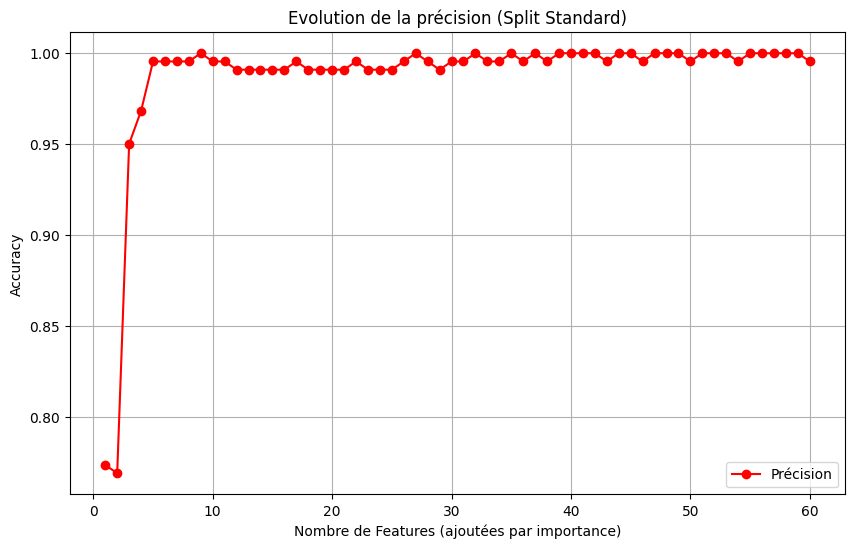

Top 5 des variables les plus influentes :
['GyroMeanZ', 'GyroSumZ', 'GyroMinZ', 'GyroStdZ', 'AccMaxY']


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

# 1. Chargement des données (Assure-toi que c'est le bon fichier avec les 60 colonnes)
# Si tu utilises sero_features_4.csv comme base :
df = pd.read_csv(r"Driving_Behavior_Dataset/Features_By_Window_Size/sero_features_4.csv") 

# 2. Importation Importances 
importances = model.feature_importances_

# 3. Préparation des Features triées
feature_names = df.drop("Target", axis=1).columns
feat_imp_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
# On trie du plus important au moins important
sorted_features = feat_imp_df.sort_values(by='Importance', ascending=False)['Feature'].tolist()

# 4. Split Classique 
X = df.drop("Target", axis=1)
y = df["Target"]

# On utilise le split standard avec shuffle (ce qui donne les 100%)
X_train_full, X_test_full, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# 5. La Boucle d'Optimisation
accuracies = []
nums = []

print("Calcul en cours...")
for k in range(1, len(sorted_features) + 1):
    # On prend les k meilleures colonnes
    top_k_features = sorted_features[:k]
    
    # On réduit le train/test à ces colonnes
    X_train_k = X_train_full[top_k_features]
    X_test_k = X_test_full[top_k_features]
    
    # Entraînement rapide
    clf = RandomForestClassifier(n_estimators=50, random_state=42, n_jobs=-1)
    clf.fit(X_train_k, y_train)
    
    # Score
    acc = accuracy_score(y_test, clf.predict(X_test_k))
    accuracies.append(acc)
    nums.append(k)

# 6. Graphique
plt.figure(figsize=(10, 6))
plt.plot(nums, accuracies, marker='o', color='red', label='Précision')
plt.title("Evolution de la précision (Split Standard)")
plt.xlabel("Nombre de Features (ajoutées par importance)")
plt.ylabel("Accuracy")
plt.grid(True)
plt.legend()
plt.show()

# Affichage du top 5
print("Top 5 des variables les plus influentes :")
print(sorted_features[:5])

In [34]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

data = pd.read_csv(r"Driving_Behavior_Dataset/Features_By_Window_Size/sero_features_4.csv")

X = data[['GyroMeanZ', 'GyroSumZ', 'GyroMinZ', 'GyroStdZ', 'AccMaxY']]
Y = data["Target"]

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42, stratify=Y)

model = RandomForestClassifier(n_estimators=200, random_state=42)

model.fit(X_train, Y_train)

Y_Pred = model.predict(X_test)

print(classification_report(Y_test, Y_Pred))

              precision    recall  f1-score   support

           1       0.98      1.00      0.99        50
           2       1.00      1.00      1.00        57
           3       1.00      0.99      0.99        70
           4       1.00      1.00      1.00        44

    accuracy                           1.00       221
   macro avg       1.00      1.00      1.00       221
weighted avg       1.00      1.00      1.00       221

